<a id="top" style="float:right;" href="http://dynfluid.ensam.eu/"><img style="height:120px;" src="http://dynfluid.ensam.eu/uas/DYNFLUID/logoPrincipal/Logo-DynFluid-Web.png"/></a>


<center>
<h3 style="color:#888888;"> <i>--  Introduction à la méthode de Boltzmann sur Réseau  --</i> </h3>
<h1> TP n°2 </h1>
<h3> La cavité entraînée </h3>

<h6><a href="mailto:simon.marie@lecnam.net">simon.marie@lecnam.net</a></h6>
</center>

<h1> 1 - Préambule </h1>

Le TP doit être réalisé en binôme ou individuellement et doit être rendu sous la forme d'un Notebook jupyter en respectant la nomenclature suivante:
<center>
<b>TP1_NOM1_NOM2.ipynb</b>
</center>

Tous les résultats, discussions, analyses, doivent donc être inclus dans le fichier.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
fs=20
plt.style.use('seaborn-dark')
plt.rc('xtick',labelsize=fs)
plt.rc('ytick',labelsize=fs)
#plt.rc('text', usetex=True)
%matplotlib inline

<h1> 2 - Présentation du TP</h1>

On se propose dans ce TP de simuler numériquement l'écoulement induit par viscosité dans une cavité de section carré. Pour pouvoir simuler les phénomènes visqueux, il est nécessssaire d'utiliser la quadrature d'ordre 3 et donc le réseau $D2Q9$.

<h2>Le modèle D2Q9</h2>

Le modèle à 9 vitesses de la méthode de Boltzmann sur réseau assure l'égalitité des moments jusqu'à l'ordre 2 et permet donc la simulation des écoulements visqueux régit par les équations de Navier-Stokes avec une limitation en nombre de Mach.
Les paramètres du modèle sont résumés dans le tableau suivant:

<table style="width:800px;text-align:center;">
<tr><td>$\widehat{c_\alpha}$</td><td>$\omega_\alpha$</td><td>$\widehat{c_0}$</td><td>$\tau_g$</td></tr>
<tr><td>$(0,0)\\ (1,0) (0,1) (-1,0) (0,-1)\\ (1,1) (-1,1) (-1,-1) (1,-1)$</td><td>$\dfrac{4}{9},\\ \dfrac{1}{9},\dfrac{1}{9},\dfrac{1}{9},\dfrac{1}{9},\\ \dfrac{1}{36},\dfrac{1}{36},\dfrac{1}{36},\dfrac{1}{36}$</td><td>$\dfrac{1}{\sqrt{3}}$</td><td width=30%>$\dfrac{1}{2}+\dfrac{\tilde{\nu}}{\widehat{c_0}^2}$</td></tr>
</table>

La fonction d'équilibre du modèle s'écrit:
$$
\displaystyle{g_{\alpha}^{eq}=\rho\omega_\alpha\left(1+\dfrac{c_{\alpha,i}u_i}{c_0^2}+\dfrac{(c_{\alpha,i}u_i)^2}{2c_0^4}-\dfrac{u_i^2}{2c_0^2}\right)}
$$

et son algorithme général:
$$
\displaystyle{g_{\alpha}^{coll} = g_{\alpha}-\dfrac{1}{\tau_g}[g_{\alpha}-g_{\alpha}^{eq}]\\
g_{\alpha}(x,y) = g_{\alpha}^{coll}(x-c_{\alpha,x},y-c_{\alpha,y})}
$$

Les variables macroscopiques sont calculées à partir des moments des fonctions de distribution:
$$
\rho=\sum_{\alpha=1}^9 g_{\alpha}
$$

$$
\rho u_x=\sum_{\alpha=1}^9 c_{\alpha,x}g_{\alpha}
$$

$$
\rho u_y=\sum_{\alpha=1}^9 c_{\alpha,y}g_{\alpha}
$$


<h2>La cavité entraînée</h2>

L'écoulement dans une cavité entrainée consite a imposer une vitesse $U_0$ constante sur le bord supérieur d'une cavité de largeur $L$ et de hauteur $L$. Le nombre de Reynolds de cet écoulement est basé sur la largeur $L$ et la vitesse d'entrainement $U_0$:
$$
Re=\dfrac{U_0 L}{\nu}=\dfrac{\tilde{U_0} \tilde{L}}{\tilde{\nu}}
$$

<center>
<img src="https://hpp.education/Lessons/LBM/ENSTA/LDCavity.png" style="width:650px;"/>
    <b><i>Figure 1: Géométrie du domaine de calcul</i></b>
</center>

Dans ce TP nous allons nous focaliser sur les solutions stationnaires de cet écoulement pour des nombres de Reynolds compris entre 100 et 1000.

<h1> 3 - Travail demandé</h1>
<h2>Définition des paramètres et des fonctions</h2>

Pour les paramètres du calcul, on prendra un domaine unitaire $(L_x, L_y)=(1,1)$ de résolution $(n_x,n_y)=(50,50)$ mailles (on fera varier la résolution pour les dernières questions). On souhaite réaliser plusieurs simulations en faisant varier le nombre de Reynolds. Le nombre de Mach sera fixé à $M_0=0.2$.

<b style="color:#0055FA">1. Completer la cellule suivante à partir des données fournies et des définition du cours.</b>

In [ ]:
ca=np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]]) #shéma D2Q9 donc 9 directions
w=[4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36] #racines des polynomes de Hermites (TP 0)
c0=1/np.sqrt(3) # facteur de normalisation des vitesses propres lorsque l'on conserve les moments jusqu'à l'ordre 2

# Domaine
nx=50
ny=50

# Taille de maille:
dx=1/nx
dy=1/ny
# Vitesse du son réelle à 293K:
c0_real=np.sqrt(1.4*287*293) #racine de gamma*R*T pour gaz parfaits

# Pas de temps:
dt=dx*c0/c0_real

# Mach:
M0=0.2 # Suffisament faible pour considérer le fluide incompressible

# vitesse de la plaque
U0=M0*c0

<b style="color:#0055FA">2. Compléter chacune des fonctions suivantes correspondant aux étapes de l'algorithme</b>
    
<b>Initialisation:</b> Définir la fonction permettant d'initialiser le domaine à une densité uniforme $\rho=1$, à vitesse nulle dans la cavité et à la vitesse $U_0$ sur le bord supérieur. Calculer également le paramètre de relaxation $\tau_g$ en fonction du nombre de Reynolds souhaité:

In [ ]:
def init(Re,nx,ny,c0,U0):
    # Initialisation du domaine
    rho,ux,uy=np.ones((nx,ny)),np.zeros((nx,ny)),np.zeros((nx,ny))
    ux[:,-1]=U0 #Fluide au repos sauf sur le bord supérieur
    mu=abs(U0)*nx/Re #augmenter Re veut dire diminuer la viscosité
    taug=1/2+3*mu
    geq=np.zeros((nx,ny,9))
    for i in range(0,9):
        geq[:,:,i]=rho[:,:]*w[i]
    print('valeur taug :'+str(taug)+'\n')
    return geq,rho,ux,uy,taug

<b>Equilibre:</b>  Dans ce TP nous avons besoin de calculer explicitement les fonctions de distribution à l'équilibre. Définir la fonction permettant la mise à jour de ces distributions en fonction des moments $\rho$, $u_x$ et $u_y$.

In [ ]:
def eq(rho,ux,uy,geq,c0,ca):
    u2=ux*ux+uy*uy
    for j in range(0,9):
        uc2=(ca[j,0]*ux)**2+(ca[j,1]*uy)**2
        uc=ca[j,0]*ux+ca[j,1]*uy
        geq[:,:,j]=rho*w[j]*(1+uc/(c0**2)+uc**2/(2*c0**4)-u2/(2*c0**2)) #Développement polynomial de la fonction d’équilibre et une quadrature de Gauss à l'ordre 2
    return(geq)


<b>Collision:</b>  Ecrire simplement l'étape de collision:

In [ ]:
def collide(gcoll,g,geq,taug):
    # Etape de collision
    for j in range (0,9):
        gcoll[:,:,j]=g[:,:,j]-1/taug*(g[:,:,j]-geq[:,:,j])
    return(gcoll)

<b>Propagation:</b> Pour cette étape on pourra utiliser du slicing plutôt qu'une boucle sur l'espace.

In [ ]:
def propagate(g,gcoll):
    g[:,:,0]=gcoll[:,:,0] #[0,0]

    g[:,1:,1]=gcoll[:,0:-1,1] #[1,0]
    g[1:,:,2]=gcoll[0:-1,:,2] #[0,1]
    g[:,0:-1,3]=gcoll[:,1:,3]#[-1,0]
    g[0:-1,:,4]=gcoll[1:,:,4]#[0,-1]

    g[1:,1:,5]=gcoll[0:-1,0:-1,5]#[1,1]
    g[1:,0:-1,6]=gcoll[0:-1,1:,6]#[-1,1]
    g[0:-1,0:-1,7]=gcoll[1:,1:,7]#[-1,-1]
    g[0:-1,1:,8]=gcoll[1:,0:-1,8]#[1,-1]
    return(g)
    # Etape de propagation

<b>Calcul des moments:</b> Calcul les variables macroscopiques $\rho$,$u_x$,$u_y$

In [ ]:
def macro(g,rho,ux,uy):
    # calcul des variables macro
    rux,ruy,rho=np.zeros((nx,ny)),np.zeros((nx,ny)),np.zeros((nx,ny))
    for i in range (0,9):
        rho+=g[:,:,i]
        rux+=g[:,:,i]*ca[i,0]
        ruy+=g[:,:,i]*ca[i,1] #On est en quadrature d'ordre 3 pour la quadrature de Gauss, donc on a egalité des moments jusqu’à l’ordre 2
    ux=rux/rho
    uy=ruy/rho
    return(rho,ux,uy)

<b>Condition aux limites solide:</b> Définir la fonction permettant de mettre à jour les distributions inconnues sur les parois solides. On utilisera ici la technique du Bounce-Back présentée dans le cours:

In [ ]:
def wall(gcoll,g,mask):
    # Paroi solide sur les bords latéraux et inférieur: Bounce back sans frottements
    g[mask==1,0]=gcoll[mask==1,0]
    g[mask==1,1]=gcoll[mask==1,3]
    g[mask==1,2]=gcoll[mask==1,4]
    g[mask==1,3]=gcoll[mask==1,1]
    g[mask==1,4]=gcoll[mask==1,2]
    g[mask==1,5]=gcoll[mask==1,7]
    g[mask==1,6]=gcoll[mask==1,8]
    g[mask==1,7]=gcoll[mask==1,5]
    g[mask==1,8]=gcoll[mask==1,6]
    return(g)

def wall(gcoll,g,mask):
    # Paroi solide sur le cylindre: Bounce back sans frottement
    g[mask==1,0]=gcoll[mask==1,0]
    g[mask==1,1]=gcoll[mask==1,3]
    g[mask==1,2]=gcoll[mask==1,4]
    g[mask==1,3]=gcoll[mask==1,1]
    g[mask==1,4]=gcoll[mask==1,2]
    g[mask==1,5]=gcoll[mask==1,6]
    g[mask==1,6]=gcoll[mask==1,5]
    g[mask==1,7]=gcoll[mask==1,8]
    g[mask==1,8]=gcoll[mask==1,7]
    return(g)

<b>Condition aux limites fluide:</b> Définir la fonction permettant de mettre à jour les moments $u_x, \rho_{top}$ et les distributions inconnues sur le bord supérieur. On utilisera les approches vues dans le cours pour le bounce-back hors équilibre:

$$
g_?-g_?^{eq}=g_\overline{?}-g_\overline{?}^{eq}
$$

Ici $\overline{?}$ désigne la vitesse opposée à la vitesse $?$.
En identifiant les distributions inconnues sur le bord supérieur, simplifier l'expression ci-dessus en fonction des moments connu sur le bord supérieur:

___
$g_4= g_2 + geq_4 - geq_2$

$g_7= g_5 + geq_7 - geq_5$

$g_8= g_6 + geq_8 - geq_6$
___


Exprimer la densité sur le bord supérieur $\rho_{top}$ en fonction des distributions connues et de la vitesse

___
$\rho_{top}=\frac{1}{1-u_x} \left(2(g_2+g_6+g_5) + g_1 + g_3\right)$

___

In [ ]:
def lid(g,ux,uy,c0,ca):
    # Conditions de vitesse au bord superieur
    ux[-1,:]=U0
    uy[-1,:]=0
    # Macro: On impose ux et on en déduit rho_w:
    rho_w=1/(1-ux)*(2*(g[:,:,6]+g[:,:,2]+g[:,:,5])+g[:,:,3]+g[:,:,0]+g[:,:,1])
    # Distributions: On impose les distributions inconnues avec le Bounce-Back hors equilibre
    b=np.copy(g)
    b=eq(rho_w,ux,uy,b,c0,ca) #recalcul des équilibres pour rho_wall
    g[-1,:,4]=g[-1,:,2]+(b[-1,:,4]-b[-1,:,2])
    g[-1,:,7]=g[-1,:,5]+(b[-1,:,7]-b[-1,:,5])
    g[-1,:,8]=g[-1,:,6]+(b[-1,:,8]-b[-1,:,6])
    return(g,ux,uy)




<h2>Calcul</h2>

<b style="color:#0055FA">3. Une fois les paramètres et les fonctions définis, fixer le nombre de Reynolds (on commencera par $Re=100$), initialiser les distributions à leur valeur d'équilibre puis définir les mailles concernées par une condition aux limites solide.</b> Pour cela on pourra utiliser une variable de type *mask* de la même taille que le domaine et valant 0 pour une maille fluide et 1 pour une maille solide.

In [ ]:
# Nombre de Reynolds:
Re=1000

# initialisation:
geq,rho,ux,uy,taug=init(Re,nx,ny,c0,U0)
g,gcoll=geq.copy(),geq.copy()

# Marquage des conditions aux limites:
# Fluide: mask=0
# Solide: mask=1
mask=np.zeros((nx,ny));
mask[:-1,0]=1 # left
mask[:-1,-1]=1 # right
mask[0,:]=1 # bottom
print(mask)

valeur taug :0.5173205080756887

[[1. 1. 1. ... 1. 1. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


On recherche une solution stationnaire pour les paramètres choisis, c'est à dire une solution dont les quantités n'évoluent plus au cours du temps. Il faut donc utiliser une boucle *while* basée sur un critère d'arrêt.
    
<b style="color:#0055FA">4. Définir une boucle de calcul reprenant l'ensemble des fonctions de la question 2. et basée sur la convergence de l'énergie cinétique moyenne dans la cavité:</b>
    
$$
\displaystyle{E_c=\dfrac{1}{V}\int_\mathcal{V}\rho\left(\dfrac{u_x^2}{U_0^2}+\dfrac{u_y^2}{U_0^2} \right) d\mathcal{V}}
$$

On prendra comme critère de convergence $\epsilon=\left|Ec^{n+1}-Ec^{n} \right|<10^{-5}$

energie cinétique initiale 0.02
327 itérations en 20.317033290863037s: Performances: 0.0402371738184652  MLUPS


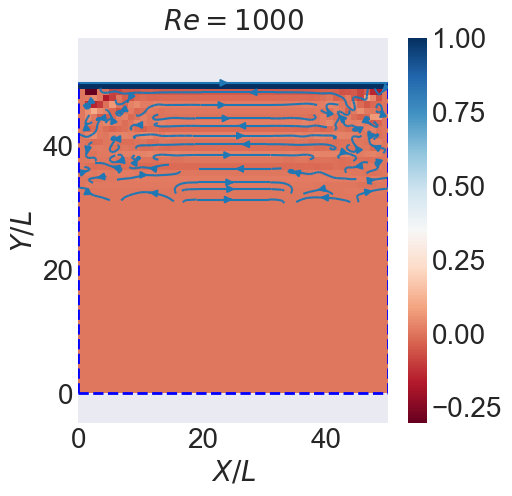

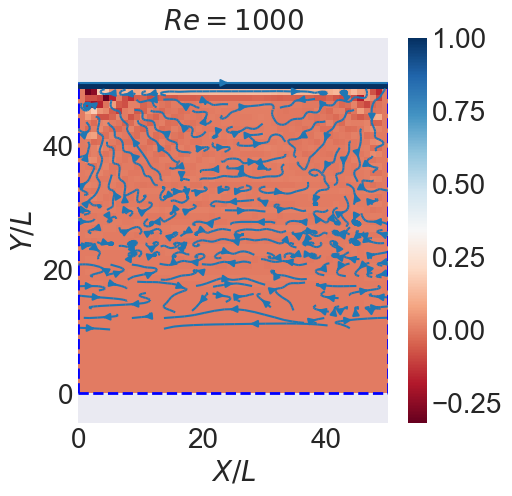

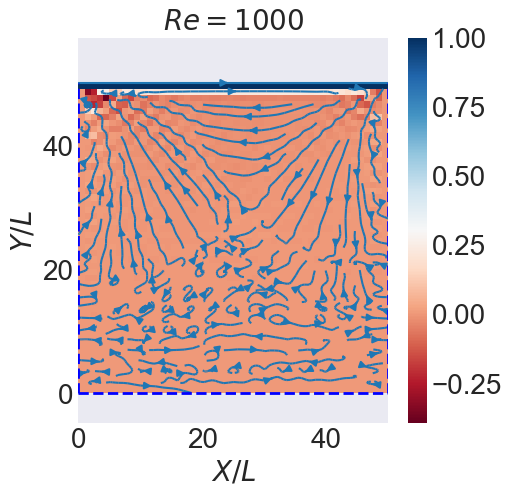

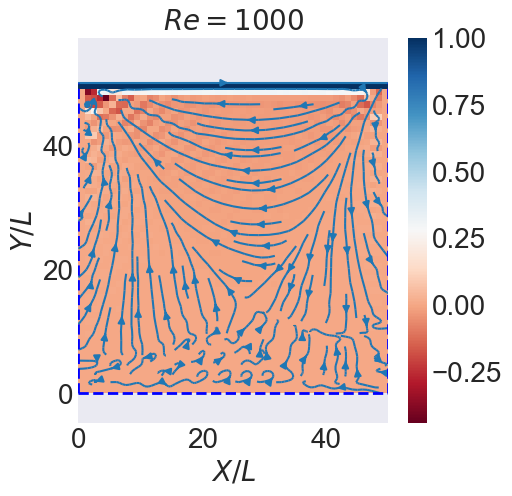

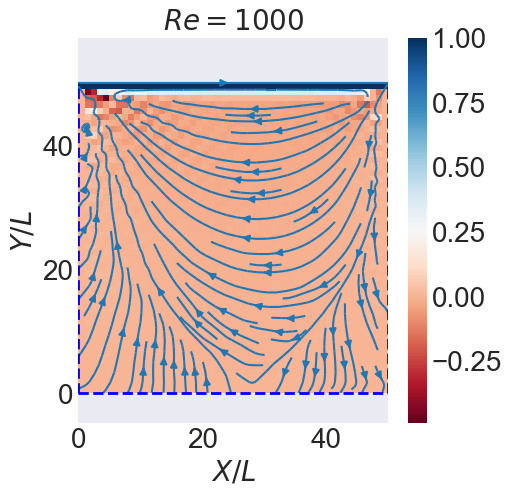

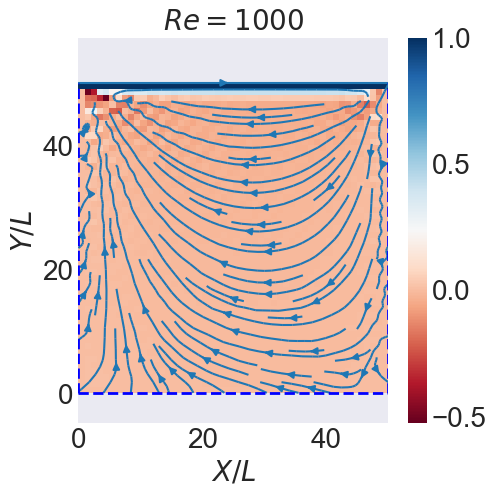

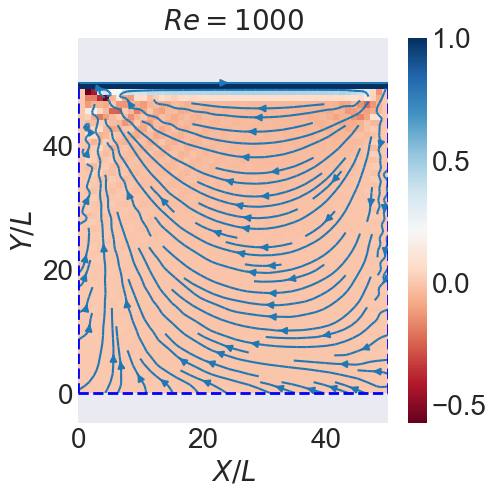

In [ ]:
eps=1
nt=0

Ec=0
for i in range(0,nx):
    for j in range(0,ny):
        Ec+=1/(nx*ny)*rho[i,j]*((ux[i,j]**2)/U0**2+(uy[i,j]**2)/U0**2) #calcul discret de Ec pour l'initialisation
print('energie cinétique initiale',Ec)#Ec=1/nx
nt+=1
eps=1
nt=0
start=time.time()
while (eps>10**-5 or nt<100): #permet de s'assurer que l'on atteint le régime permanent
    nt+=1
    rho,ux,uy=macro(g,rho,ux,uy)
    geq=eq(rho,ux,uy,geq,c0,ca)
    gcoll=collide(gcoll,g,geq,taug)
    g=propagate(g,gcoll)
    g=wall(gcoll,g,mask)
    g,ux,uy=lid(g,ux,uy,c0,ca);


    Ec_av=Ec
    Ec=0
    if nt%20==0 and nt<150: # Permet de visualiser la diffusion du mouvement dans le fluide
        fig=plt.figure(figsize=(5,5))
        x=np.linspace(0,50,nx)
        y=np.linspace(0,50,ny)
        plt.streamplot(x,y,ux,uy)
        plt.plot([0, 50], [0, 0], 'b--', lw=2)
        plt.plot([0, 0], [0, 50], 'b--', lw=2)
        plt.plot([50, 50], [0, 50], 'b--', lw=2)
        plt.xlabel(r'$X/L$',fontsize=fs);plt.ylabel(r'$Y/L$',fontsize=fs)
        plt.title(r'$Re='+str(Re)+'$',fontsize=fs);plt.axis('equal');
        plt.pcolormesh(ux/U0,cmap='RdBu')
        plt.colorbar()
        plt.axis('equal')
    for i in range(0,nx):
        for j in range(0,ny):
            Ec+=1/(nx*ny)*rho[i,j]*((ux[i,j]**2)/U0**2+uy[i,j]**2/U0**2)
    eps=abs(Ec-Ec_av)
    #print(eps)
tcal=time.time()-start
print(str(nt)+" itérations en "+str(tcal)+"s: Performances: "+str((1e-6)*nt*nx*ny/tcal)+"  MLUPS") #Après avoir faire tourné cette boucle, on trouve 1,3 MLUPS de calcul. Cela est cohérent avec la puissance de notre machine.

<h2>Analyse des résultats</h2>

<b style="color:#0055FA">5. Comparer les performances du code obtenu à celles du TP1. Commenter</b>

____
Qualitativement, passer à un modèle D2Q9 nous oblige à calculer les moments d'ordre 2. Le calcul est donc plus lent.

____


<b style="color:#0055FA">6. Tracer les lignes de courant de l'écoulement et commenter la figure obtenue. (On pourra utiliser la fonction <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.streamplot.html">streamplot</a>)</b>

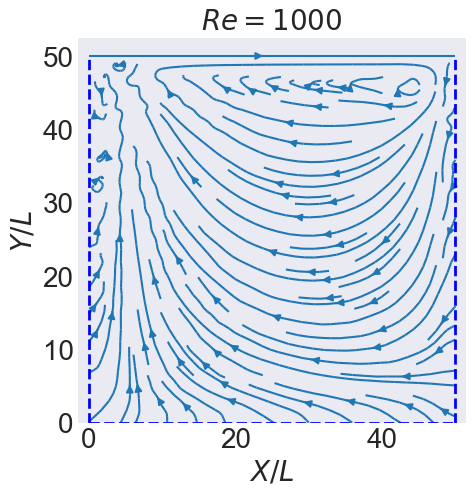

In [ ]:
fig=plt.figure(figsize=(5,5))
x=np.linspace(0,nx,nx)
y=np.linspace(0,nx,ny)
plt.streamplot(x,y,ux,uy)
plt.plot([0, nx], [0, 0], 'b--', lw=2)
plt.plot([0, 0], [0, nx], 'b--', lw=2)
plt.plot([nx, nx], [0, nx], 'b--', lw=2)
plt.xlabel(r'$X/L$',fontsize=fs);plt.ylabel(r'$Y/L$',fontsize=fs)
plt.title(r'$Re='+str(Re)+'$',fontsize=fs);plt.axis('equal');

La figure obtenue semble cohérente. En effet, on observe bien notre condition de bounce back sans frottement : les lignes de courants sur les bords et les parois satisfont la condition de glissement sans frottement. D'autre part, on retrouve la ligne de courant associée au jet fluide sur la partie supérieure. On peut observer des débuts de zones de "fluide mort", qui seront sources de recirculation à haut Reynolds, situées dans les coins de la cavité. On peut aussi observer que le centre du tourbillon n'est pas au centre de la cavité. Cela est du aux effets de viscosité. Si on augmente le Reynolds, on diminue la viscosité et le centre du tourbillon se rapproche du centre de la cavité.

Les fichiers **Ghia82data_ux.csv** et **Ghia82data_uy.csv** (à télécharger sur le Moodle) contiennent des résultats de référence  enregistrés le long des lignes $x=L/2$ et $y=L/2$ respectivement. Les fichiers sont constitués de plusieurs colonnes. La première correspond à la coordonnée du point de mesure et les autres aux différentes valeurs de Reynolds:

<table>
    <th>$x/y$</th><th>$u_{x/y}$ $Re=100$</th><th>$u_{x/y}$ $Re=400$</th><th>$u_{x/y}$ $Re=1000$</th><th>$u_{x/y}$ $Re=3200$</th><th>$u_{x/y}$ $Re=5000$</th><th>$u_{x/y}$ $Re=7500$</th><th>$u_{x/y}$ $Re=10000$</th>
    </table>
    
Les grandeurs de vitesse sont normalisées par la vitesse d'entrainement $U_0$.

(0.0, 50.0, 0.0, 50.0)

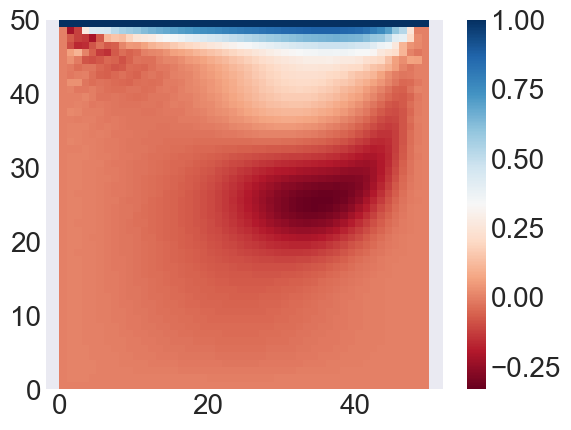

In [ ]:
plt.pcolormesh(ux/U0,cmap='RdBu')
plt.colorbar()
plt.axis('equal')

La vitesse ux est cohérente car on a à la fois une vitesse nulle sur les bords, une vitesse égale à U0 sur le dessus ainsi qu'une vitesse négative dans la partie inférieure.

(0.0, 50.0, 0.0, 50.0)

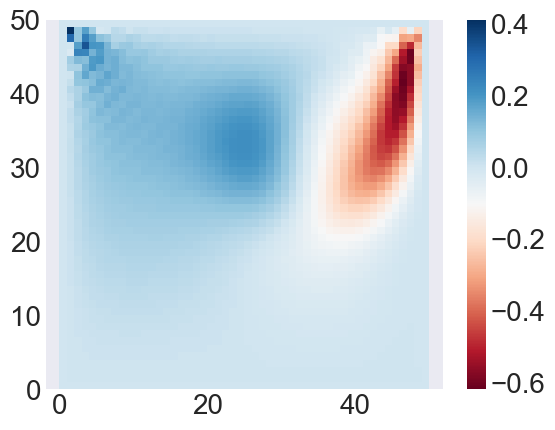

In [ ]:
plt.pcolormesh(uy/U0,cmap='RdBu')
plt.colorbar()
plt.axis('equal')

On a bien un cisaillement de la vitesse uy dans le sens du tourbillon

In [ ]:
#À quelle colonne du fichier csv on compart nos données ?
place=1 # 1 : Re=100, 2=Re=


Ghia=np.loadtxt('Ghia82data_ux.csv')
Ghia_y=np.loadtxt('Ghia82data_uy.csv')
print(Ghia[1:,0])
print(Ghia_y[1:,0])
pnt=[] #contient les positions des points de références sur notre simulation pour les ux
for i in range(1,len(Ghia[:,0])):
    pnt+=[int(Ghia[i,0]/dx)]
for i in range(len(pnt)):
    if pnt[i]>=nx:
        pnt[i]=nx-1

pnt_y=[] #contient les positions des points de références sur notre simulation pour les ux
for i in range(1,len(Ghia_y[:,0])):
    pnt_y+=[int(Ghia_y[i,0]/dx)]
for i in range(len(pnt_y)):
    if pnt[i]>=nx:
        pnt[i]=nx-1

[1.     0.9766 0.9688 0.9609 0.9531 0.8516 0.7344 0.6172 0.5    0.4531
 0.2813 0.1719 0.1016 0.0703 0.0625 0.0547 0.    ]
[1.     0.9688 0.9609 0.9531 0.9453 0.9063 0.8594 0.8047 0.5    0.2344
 0.2266 0.1563 0.0938 0.0781 0.0703 0.0625 0.    ]


<b style="color:#0055FA">7. Comparer les profils obtenus pour $u_x$ et $u_y$. On pourra faire varier le critère de convergence et commenter son influence sur les résultats.</b>

[ 1.       0.84123  0.78871  0.73722  0.68717  0.23151  0.00332 -0.13641
 -0.20581 -0.2109  -0.15662 -0.1015  -0.06434 -0.04775 -0.04192 -0.03717
  0.     ]
[1.0, 0.8077450874072456, 0.8077450874072456, 0.8077450874072456, 0.5301779627832092, 0.13317353367191861, 0.04556394577685483, -0.12234431995969766, -0.19733150511697145, -0.1747629563464213, -0.07475216458486464, -0.04580809854133588, -0.03249766745974481, -0.02060338809380312, -0.02060338809380312, -0.013294575810214686, 0.0]


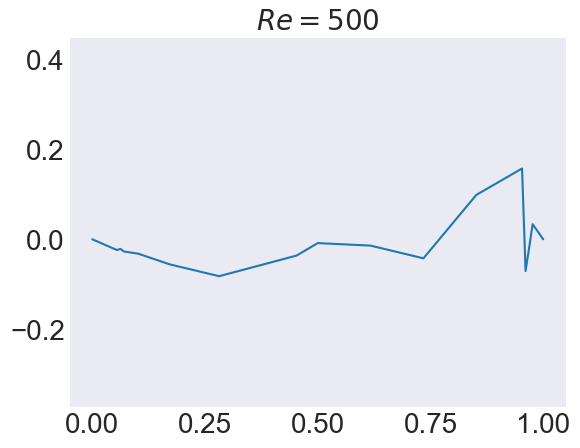

In [ ]:
cal_ux=[]
for i in pnt:
    cal_ux+=[ux[i,nx//2]/U0]

plt.title(r'$Re='+str(Re)+'$',fontsize=fs);plt.axis('equal');
plt.xticks(np.linspace(0,1,5))
print(Ghia[1:,place])
print(cal_ux)

plt.plot(Ghia[1:,0],Ghia[1:,place]-cal_ux)
plt.show()

<b style="color:#0055FA">8. Etudier la précision des résultats en fonction du nombre de Mach pour $R_e=100$. Commenter </b>

[ 0.      -0.05906 -0.07391 -0.08864 -0.10313 -0.16914 -0.22445 -0.24533
  0.05454  0.17527  0.17507  0.16077  0.12317  0.1089   0.10091  0.09233
  0.     ]
[0.0, -0.004546443640237575, -0.004546443640237575, -0.004546443640237575, -0.01250495567482215, -0.17537167291301853, -0.32943751962895224, -0.2945456822620505, -0.19733150511697145, -0.13819418756319826, -0.05253064553781778, -0.020260205905172274, -0.007952656054019515, 8.039341583891354e-05, 8.039341583891354e-05, 0.0015249658128449071, 0.0]


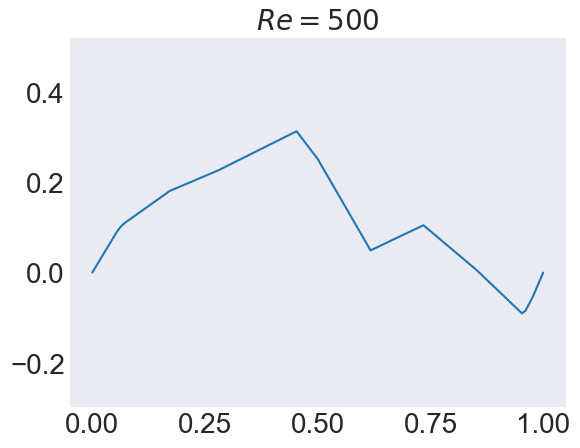

In [ ]:
cal_uy=[]
for i in pnt:
    cal_uy+=[ux[nx//2,i]/U0]

plt.title(r'$Re='+str(Re)+'$',fontsize=fs);plt.axis('equal');
plt.xticks(np.linspace(0,1,5))
print(Ghia_y[1:,place])
print(cal_uy)

plt.plot(Ghia[1:,0],Ghia_y[1:,place]-cal_uy)
plt.show()

**Commentaires**

___
On obtient un écart relativement faible pour les valeurs de ux. Notre simulation semble donc cohérente. Némamoins, notre ux calculé varie brutalement près de la parois tandis que le ux fournit lui augmente progressivement plus on se rapproche de la surface.


L'écart pour uy est aussi faible
___

<b style="color:#0055FA">8. Compléter le tableau suivant en indiquand le nombre d'itération nécessaire à la convergence en faisant varier le Reynolds et la résolution. Que constatez-vous pour les faibles résolutions et les hauts Reynolds. Expliquez </b>

Nx\Re | 100 | 400 | 1000 | 3200
 --- | --- | --- | --- | ---
 50 | ? | ? | x | x
100 | ? | ? | x | x
200 | ? | ? | ?  | ?
400 | ? | ? | ?  | ?


**Commentaires**
___


___

# Conclusion

Présenter ici la synthèse de votre TP en décrivant les points importants et les principaux résultats.


En conclusion, ce TP a été l'occasion de coder de A à Z un algorithme de LBM.
Nous avons pu nous mettre directement à l'échelle logique pour implémenter les étapes importantes : collide, propagate et conditions limites. Le travail a été ardu, notamment sur la définition de la fonction lid et wall, les plus difficiles d'un point de vue conceptuel. Nous avons du définir des fonctions d'équilibre sur les bords du domaine, ce qui est plus dur à visualiser.

La finalité est une modélisation d'un phénomène complexe qui fait intervenir des phénomènes visqueux. Sous son apparence d'algorithme simple, à partir d'une simple loi de collision, la LBM permet une modélisation fine et complexe des phénomènes physiques.

Même si nous ne sommes pas parvenus à terminer le TP, nous avons passé un temps considérable à anlayser les résultats des simulations. Nous ne nous sommes pas contenté de l'allure des lignes de courants mais avons directement regardé les profils de vitesse ux et uy et les avons comparés avec d'autres résultats comme Gia ou trouvés en ligne. Malgré ces efforts, nous ne sommes pas parvenus à finir le TP dans le temps imparti.

La comparaison des performances en terme de raffinement de maillage (pour des valeurs de nx de 400 notamment) et hauts Reynolds nous aurait sûrement permis de mettre en lumière l'importance de la parallélisation dans le calcul et la performance de l'algorithme de la LBM. Nos machines sont modestes et l'optimisation des calculs seraient en effet très pertinente. Nous pouvons néanmoins noter que nous avons limité l'utilisation des boucles for et que nous avons réemployé avec profit la méthode de slicing vu dans le TP précédent dans un soucis d'efficacité.